# Exercise 1

Here we will use simply the dataset of porosity vs NGR and %Carbonate that we used before. This is a simplified version of the dataset, and it contains no labels (only numerical values are included). The data file is saved in 'Datasets/core_data.csv'.

You are now an expert at data preparation, so do the following for the above dataset:

* Remove duplicates
* Separate the target (`porosity %` - call it `y`) from the features (call them `X`)
* Split the dataset into 70% training, 30% testing. To ensure we get the same results use a `random_state` value of 42.
* Using a pipeline, impute missing values using a `SimpleImputer` class with a `mean` strategy and a `MinMaxScaler`

You should know how to do all of the above except for splitting the target and the features. You can use the brief code block below for inspiration:

```python
# Create features (drop the target columns)
X = data.drop(columns = 'porosity %')

# Create target
y = data['porosity %'] 

# Split the data using train/test split. Note that when you provide two dataframes (X and y), it will split them up 
# in the order shown
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)
```

After following your data preparation pipeline, you should end up with 4 dataframes (`X_train`, `X_test`, `y_train`, `y_test`), two of them scaled (`X_train`, `X_test`).

**Tip 1:** If you get stuck, you can refer to last week's exercise (this is essentially the same workflow). That said, I do recommend that you try and go as far as you can on your own: it is important to practice to be able to do it without the need to refer to previous code...

**Tip 2:** The `sklearn` `Pipeline` class will return a Numpy Array, not a Pandas Dataframe. For many applications, this is ok as you no longer need to explore your dataset once it has been prepared; you simply need to send it to another `sklearn` object, which accept numpy arrays without complaint. But in our case, we will want to convenience of calling specific columns later. So make sure that both `X_train` and `X_test` are Dataframes (you can refer to the documentation to see how to turn Numpy arrays directly into DataFrames). 

In [2]:
# YOUR CODE HERE
# Import everything
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

data = pd.read_csv('Data/core_data_trunc.csv')

data.drop_duplicates(inplace = True)

# Split the data into features (X) and the target variable (y)
X = data.drop(columns = 'Porosity (vol%)')
y = data['Porosity (vol%)']

# Split into training and testing sets
# Each sample in X_train has a corresponding y_train value
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# define function that removes negative NGR
def remove_negative_values(df):
    df = df[df['NGR total counts (cps)'] > 0]    
    return df

X_train = remove_negative_values(X_train)
X_test = remove_negative_values(X_test)

# Create a pipeline that does our preprocessing for us
pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

# Fit the pipeline to the X_train object, then transform the data
# Note that we don't need to do the whole numeric column thing from Lecture 4 because
# our data no longer contains any non-numeric data
X_train_prep = pipe.fit_transform(X_train)
X_test_prep = pipe.transform(X_test)

# Prove to yourself that all values have been scaled from 0-1
pd.DataFrame(X_train_prep, columns = X_train.columns).describe()

,Depth CSF-A (m),NGR total counts (cps),Reflectance L*,Reflectance a*,Reflectance b*
count,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000
mean,0.157809,0.308861,0.461757,0.295851,0.389865
std,0.194801,0.166321,0.130924,0.086793,0.089343
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.037054,0.198967,0.373418,0.242105,0.321976
50%,0.088918,0.275715,0.449367,0.270175,0.376491
75%,0.196690,0.398285,0.534177,0.329825,0.454855
max,1.000000,1.000000,1.000000,1.000000,1.000000


# Exercise 2: Incorporating ML models in pipelines

By now you should be somewhat familiar with pipelines since you've been using them to prepare your data since the last lecture. But the real power of pipelines is that they allow you to pair data preparation and model training into a single pipeline. All you have to do is simply add a predictor (i.e., a model) at your last step in our pipeline. Then, to assess our model, all we need to do is:

* `fit` your pipeline on `X_train`
* use your pipeline to `predict` the `y_test`

Note that you no longer need to save the intermediate transformed `X_train` and `X_test` dataframe: the `transform` method is called under the hood by the pipeline for you.

In the following cell, redo Exercise 1 but this time incorporate a `LinearRegression()` model into your pipeline, `fit` it, and create a `y_pred` prediction from your test set. Call your pipeline `ols_pipe` (for 'ordinary least square'): we will reuse it in the rest of this notebook.

**Tip:** You will need to resplit the data as the current `X_train` and `X_test` are already scaled, but you can copy most of your code from Exercise 1 so this will be quick.

In [3]:
from sklearn.linear_model import LinearRegression

# Repeat the preprocessing steps from Exercise 1
data = pd.read_csv('Data/core_data_trunc.csv')

data.drop_duplicates(inplace = True)

X = data.drop(columns = 'Porosity (vol%)')
y = data['Porosity (vol%)']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

def remove_negative_values(df):
    df = df[df['NGR total counts (cps)'] > 0]    
    return df

X_train = remove_negative_values(X_train)
X_test = remove_negative_values(X_test)

# The only difference is that now we add the linear regression model at the end
ols_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('linreg', LinearRegression())
])

# Remember that when using a pipeline, we are very specifically asking for an output from
# the very last element in the pipeline

# Thus, we first want to FIT our linear regression model to training set. To do this, we need
# to give it the X and y data from the training set:
ols_pipe.fit(X_train, y_train)

# We can then used the FITTED model to predict y data for a given set of X data from the testing set
y_pred = ols_pipe.predict(X_test)

# You can do a crude comparison between the predicted (top) and the actual (bottom) data 
# Here i'm comparing the first 8 predicted/actual porosities...
np.array([np.round(y_pred, 2), y_test])[:, :8]

array([[57.47, 65.94, 64.71, 63.85, 55.76, 55.33, 52.05, 53.59],
       [57.  , 75.6 , 73.8 , 62.2 , 56.2 , 27.6 , 56.2 , 49.  ]])

# Exercise 3

Following the example above, now calculate the MSE, RMSE, MAE, Max Error and R^2 for your model, and print the results neatly.

**Tip:** You will need to check the `sklearn` documentation to be able to find the names of the different metrics. 

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score

# All scoring takes in the actual and predicted values in that order
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

rsquared = r2_score(y_test, y_pred)

max_error = max_error(y_test, y_pred)

# I have rounded everything to 2 decimal points for clarity
# The important thing to learn here is when to use which metric. 
# I personally really like using RMSE since that's the easiest metric to explain
print('MSE =', np.round(mse, 2))
print('RMSE =', np.round(rmse, 2))
print('MAE =', np.round(mae, 2))
print('R2 =', np.round(rsquared, 2))
print('Max Error =', np.round(max_error, 2))

MSE = 113.85
RMSE = 10.67
MAE = 8.17
R2 = 0.59
Max Error = 50.35


# Exercise 4

Now that you know how to extract specific bits of a trained pipeline, do the following:

1. Create a dataframe that contains 6 columns and 2 rows. The six columns will be the intercepts calculated by the machine learning algorithms: these are the coefficients given to each feature of the model. We will have two rows because we want to compare the values returned by the `LinearRegression` pipeline and the `SGDRegressor` pipeline. Make sure that you use the column names from the original X_train dataset for your coefficients; the coefficients returned by the `.coefs` attribute are in the same order as in the training data.
2. Check whether the intercept and coefficients are similar between the two models: does the SGD approximation do a good job at capturing the coefficients identified by the OLS model?
3. Based on the values of the coefficients, can you tell which of the 5 features we have used to predict porosity is the most important? Remember that because our data is scaled (i.e., all values are between 0 and 1) the coefficient is a direct indication of the relative importance of each feature. If you were to keep only 2 features to retrain a predictive model of porosity, which features would you keep?

In [5]:
# Instantiate and train the pipeline object
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 50, tol = 0, penalty = None, eta0 = 0.1, random_state = 42)

# Following best practice, let's define a pipeline:

sgd_pipe = Pipeline([('imputer', SimpleImputer()),
                    ('scaler', MinMaxScaler()),
                    ('regressor',sgd_reg)])

sgd_pipe.fit(X_train, y_train)

# Extract the coefficients from the LinearRegression pipeline
# and the SGD regressor pipeline

ols_coefs = ols_pipe['linreg'].coef_
sgd_coefs = sgd_pipe['regressor'].coef_

# put them into a numpy array
coef_arr = np.array([ols_coefs, sgd_coefs])

# Create a dataframe from that numpy array
# Give the dataframe the appropriate column and index names
display(pd.DataFrame(coef_arr, columns = X_train.columns, index = ['ols', 'sgd']))

print('LinearRegression intercept:', ols_pipe['linreg'].intercept_)
print('SGDRegressor intercept:', sgd_pipe['regressor'].intercept_)

# Since our data is scaled, the coefficient allows for a direct comparison between features
# Thus, depth is twice as important as NGR counts, 5-6 times more important than Reflectance, etc.

# For those of you who are interested in math, what's happening is:
# (depth * -64.09) + (NGR * -34.6) + (Reflectance L * -13.2) + ... + 85.19 (intercept) = predicted_value

# You can prove this to yourself below; both pieces of code will give you the same result:
#     (X_test_prep[0,:] * ols_pipe['linreg'].coef_).sum() + ols_pipe['linreg'].intercept_
#     ols_pipe.predict(X_test)[0]

,Depth CSF-A (m),NGR total counts (cps),Reflectance L*,Reflectance a*,Reflectance b*
ols,-64.091323,-34.633535,-13.216320,-12.008224,-2.911873
sgd,-64.094330,-34.175381,-13.046445,-10.858006,-2.445969


LinearRegression intercept: 85.19402041232287
SGDRegressor intercept: [84.19691801]


# Exercise 5

Classification models (in our case, we'll be using the `LogisticRegression()` model in the `linear_model` module of `sklearn`) are trained exactly the same way as a regression model. Of course, the target variable is different: instead of a continuous value, the y_train and y_test values are now discrete classes.

You'll be working with the same dataset in this exercise, as you did in the previous exercises, but you will first transform the variable '% porosity' into a class.

Do the following:

1. Open the file 'Datasets/core_data.csv' once again.
2. Create an `X` variable containing all of the features, except porosity.
3. Create a `y` variable where the value is 0 if the sample has <53% porosity, or 1 if it has >=53% porosity. There are several ways to do this, but I recommend using an anonymous function and the `.apply()` dataframe method (this is the simplest)
4. Train-test split as before (70/30, random_state=42)
5. Write a pipeline that includes an imputer (strategy=mean), a scaler (MinMax) and a LogisticRegression classifier. Fit your pipeline to the `X_train` and `y_train` data.
6. Predict the class of your `X_test` and save it as `y_pred`

In [6]:
# Once again, the preprocessing steps are exactly the same
# with the small exception that LogisticRegression is used for final object in the pipeline
from sklearn.linear_model import LogisticRegression

data = pd.read_csv('Data/core_data_trunc.csv')
data.drop_duplicates(inplace = True)

# Repeat the standard preprocessing steps
# However, we want to transform the porosity data from a numeric value to a categorical
# The porosity data is now either 0 (low) or 1 (high).
X = data.drop(columns = 'Porosity (vol%)')
y = data['Porosity (vol%)'].apply(lambda x: np.where(x < 53, 0, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=42)

# Create a LogisticRegression pipeline
pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('logreg', LogisticRegression())
])

# Fit our pipeline
pipe.fit(X_train, y_train)

# Use our trained pipeline to predict the y values for a given X_test
y_pred = pipe.predict(X_test)

np.array([y_pred, y_test])

array([[0, 1, 1, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 1]], dtype=int64)

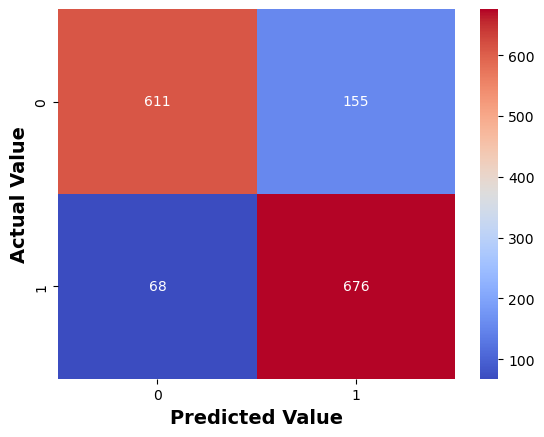

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generates a NxN confusion matrix, where N is the number of classes being predicted
# Output is a numpy array that we can visualize using a heatmap
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap. fmt = 'g' prevents seaborn from using scientific notation on this plot
sns.heatmap(cm, annot = True, cmap = 'coolwarm', fmt = 'g')

plt.xlabel('Predicted Value', fontsize = 14, weight = 'bold')
plt.ylabel('Actual Value', fontsize = 14, weight = 'bold');

## Exercise 6

Congratulations! This is the last exercise of the day (unless you attempt the optional one). In this exercise, you will compute all of the metrics described above for your LogisticRegression model. This is similar to exercise 3, but this time for a classification task.

**Tip:** Again, the hardest bit of this exercise is actually to find how the different metrics are named in `sklearn`. The rest you have done before - so consult the documentation!

In [9]:
# Most of the information here can actually be gleaned from the confusion matrix, but its good to know 
# how to calculate the actual values from sklearn

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

accuracy=accuracy_score(y_test, y_pred)

precision = precision_score(y_test,y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print('Accuracy =', np.round(accuracy, 2))
print('Precision =', np.round(precision, 2))
print('Recall =', np.round(recall, 2))
print('F1 =', np.round(f1, 2))

# Don't worry if the numbers are very slightly different: these could be due to differences
# in preprocessing, etc.

Accuracy = 0.85
Precision = 0.81
Recall = 0.91
F1 = 0.86
